In [1]:
from openmm.app import *
from openmm import *
from openmm.unit import *
from sys import stdout
import time
import mdtraj as md
import numpy as np
import matplotlib.pyplot as plt

In [2]:
diala = md.load_pdb('diala.pdb')
diala.topology

<mdtraj.Topology with 1 chains, 3 residues, 22 atoms, 21 bonds at 0x7f52f012cee0>

In [3]:
coord = md.load('diala.inpcrd', top='diala.prmtop')

In [4]:
phi_atoms=md.compute_phi(coord)[0].tolist()
phi_atoms

[[4, 6, 8, 14]]

In [5]:
psi_atoms=md.compute_psi(coord)[0].tolist()
psi_atoms

[[6, 8, 14, 16]]

In [6]:
start_time = time.time()

In [158]:
prmtop = AmberPrmtopFile('diala.prmtop')
inpcrd = AmberInpcrdFile('diala.inpcrd')
pdb = PDBFile('diala.pdb')

system = prmtop.createSystem(nonbondedMethod=NoCutoff, constraints=HBonds, implicitSolvent=OBC2)

phi_force = CustomTorsionForce('theta')
phi_force.addTorsion(phi_atoms[0][0], phi_atoms[0][1], phi_atoms[0][2], phi_atoms[0][3])

psi_force = CustomTorsionForce('theta')
psi_force.addTorsion(psi_atoms[0][0], psi_atoms[0][1], psi_atoms[0][2], psi_atoms[0][3])

phi_bias = BiasVariable(phi_force, -np.pi, np.pi, 0.35, True)
psi_bias = BiasVariable(psi_force, -np.pi, np.pi, 0.35, True)

meta = Metadynamics(system, [phi_bias, psi_bias], 298.15*kelvin, 6.0, 1.2*kilojoules_per_mole, 500)

integrator = LangevinMiddleIntegrator(298.15*kelvin, 1/picosecond, 0.002*picoseconds)

platform = Platform.getPlatformByName('CUDA')
properties = {'Precision': 'mixed'}

simulation = Simulation(prmtop.topology, system, integrator, platform, properties)

simulation.context.setPositions(inpcrd.positions)
simulation.minimizeEnergy()

simulation.reporters.append(DCDReporter('diala-test-output.dcd', 100))
simulation.reporters.append(StateDataReporter(stdout, 1000, step=True,
        potentialEnergy=True, temperature=True))

meta.step(simulation, 100000)

print ("simulation time:", time.time() - start_time, "s")

#"Step","Potential Energy (kJ/mole)","Temperature (K)"
1000,-114.28658852964178,272.1476760229899
2000,-126.43912828277362,279.5663911274765
3000,-111.58909674653223,183.0135018438365
4000,-102.30932561111375,363.61751422050844
5000,-112.96405971597794,310.39541346066426
6000,-114.1319057271681,225.34453112454608
7000,-102.0071472344455,387.9003047044787
8000,-108.08162463477454,234.3702260797835
9000,-95.24576082881637,378.44425437309286
10000,-70.03745019726001,279.69709808751907
11000,-99.8426648425575,334.1284365863508
12000,-114.4026397818813,253.70889774261678
13000,-101.24188717927794,268.25995393399376
14000,-119.83342068469874,232.28934180226364
15000,-109.99279966353787,184.03862247108012
16000,-119.82915409924422,268.6617846085916
17000,-115.6001907246181,287.2251097162446
18000,-110.7758515844388,251.5656396125473
19000,-119.94082566975571,296.29354162942656
20000,-116.37075289119186,370.99680135872705
21000,-98.72780853753859,354.5765810545253
22000,-103.07912120248807,246

In [159]:
traj = md.load('diala-test-output.dcd', top = 'diala.prmtop')

cv_tuple=[]

for crd in traj.xyz: #getting atom coordinates in each frame to make the simulation context
    simulation.context.setPositions(crd)
    cv_tuple.append(meta.getCollectiveVariables(simulation)) #get CV per frame

In [160]:
cv_tuple

[(-2.748260021209717, 2.8453776836395264),
 (-2.8278326988220215, 2.926905870437622),
 (-2.525961399078369, 2.459092140197754),
 (-2.533644914627075, 2.429718255996704),
 (-3.015126943588257, 2.541511297225952),
 (-2.8743717670440674, -2.9645092487335205),
 (-2.8174078464508057, -2.707721471786499),
 (-2.922408103942871, -3.140212297439575),
 (-2.452460289001465, 2.8592052459716797),
 (-2.7785918712615967, 2.0488693714141846),
 (-2.8531861305236816, 2.0043599605560303),
 (-2.613748550415039, 2.549225091934204),
 (-2.9496700763702393, 2.7552177906036377),
 (-2.647369146347046, 2.9555516242980957),
 (-2.6124298572540283, 2.623147964477539),
 (-2.801487922668457, 2.4870734214782715),
 (-2.47640061378479, 2.7641210556030273),
 (-2.9755733013153076, 2.677952766418457),
 (-2.8607194423675537, 2.918482542037964),
 (-2.669706106185913, 3.132533311843872),
 (-2.738802671432495, 2.6592025756835938),
 (-2.8048455715179443, 2.1526455879211426),
 (-2.1496081352233887, 2.0659327507019043),
 (-1.8957

In [164]:
phi_cv=[]
psi_cv=[]

for i in cv_tuple:
    phi_cv.append(i[0])
    psi_cv.append(i[1])

In [165]:
t = np.arange(0.0, 2.0, 0.002) #2 ns simulation

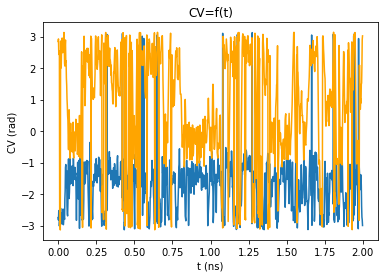

In [166]:
fig,ax = plt.subplots()
ax.plot(t, phi_cv, label = 'phi')
ax.plot(t, psi_cv, label = 'psi', color = 'orange')
ax.set(xlabel='t (ns)', ylabel='CV (rad)', title='CV=f(t)')

fig.savefig('cv.png')
plt.show()

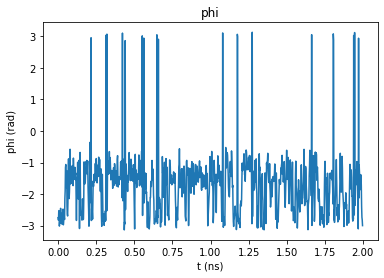

In [167]:
fig,ax = plt.subplots()
ax.plot(t, phi_cv)
ax.set(xlabel='t (ns)', ylabel='phi (rad)', title='phi')

fig.savefig('phi.png')
plt.show()

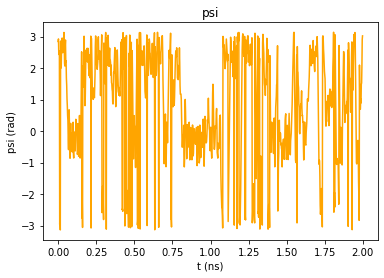

In [168]:
fig,ax = plt.subplots()
ax.plot(t, psi_cv, color='orange')
ax.set(xlabel='t (ns)', ylabel='psi (rad)', title='psi')

fig.savefig('psi.png')
plt.show()

In [169]:
fe = []
for i in meta.getFreeEnergy():
    fe.append(i._value)

In [170]:
fe

[array([-9.28872014e+00, -1.03179859e+01, -1.12500237e+01, -1.20380188e+01,
        -1.26400921e+01, -1.30242382e+01, -1.31726292e+01, -1.30845832e+01,
        -1.27777475e+01, -1.22873426e+01, -1.16635840e+01, -1.09675773e+01,
        -1.02660832e+01, -9.62559456e+00, -9.10620501e+00, -8.75580243e+00,
        -8.60516874e+00, -8.66457588e+00, -8.92238501e+00, -9.34595885e+00,
        -9.88489933e+00, -1.04762812e+01, -1.10512438e+01, -1.15420986e+01,
        -1.18890577e+01, -1.20457811e+01, -1.19831586e+01, -1.16910208e+01,
        -1.11777646e+01, -1.04681338e+01, -9.59958828e+00, -8.61781017e+00,
        -7.57193220e+00, -6.51003788e+00, -5.47538196e+00, -4.50363521e+00,
        -3.62128914e+00, -2.84519346e+00, -2.18306563e+00, -1.63472569e+00,
        -1.19377584e+00, -8.49455904e-01, -5.88449364e-01, -3.96474456e-01,
        -2.59557419e-01, -1.64943037e-01, -1.01646345e-01, -6.06868009e-02,
        -3.50709637e-02, -1.96011681e-02, -1.05865259e-02, -5.52137192e-03,
        -2.7

The length of the free energy values depends on the number of grid points specified

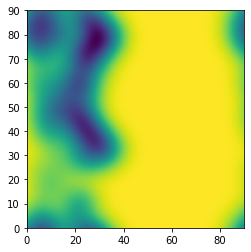

<Figure size 432x288 with 0 Axes>

In [171]:
plt.imshow(meta.getFreeEnergy())
plt.ylim(0,90)
plt.xlim(0,90)
plt.show()
plt.savefig('free-energy.png')

In [172]:
fe[0][0]

-9.288720142901761

In [173]:
meta._totalBias

array([[ 7.74060012,  8.59832157,  9.37501978, ...,  5.93556079,
         6.84100331,  7.74060012],
       [ 7.13987944,  7.96015734,  8.70794098, ...,  5.43189512,
         6.28551104,  7.13987944],
       [ 6.5030575 ,  7.27891654,  7.99006993, ...,  4.90302716,
         5.699899  ,  6.5030575 ],
       ...,
       [ 8.77800219,  9.68604086, 10.49388126, ...,  6.81927851,
         7.80964615,  8.77800219],
       [ 8.29074586,  9.17789559,  9.97473182, ...,  6.40161613,
         7.35292502,  8.29074586],
       [ 7.74060012,  8.59832157,  9.37501978, ...,  5.93556079,
         6.84100331,  7.74060012]])

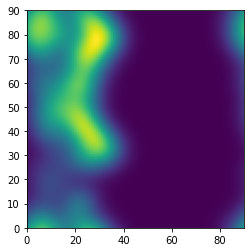

In [174]:
plt.imshow(meta._totalBias)
plt.ylim(0,90)
plt.xlim(0,90)
plt.savefig('total-bias.png')

In [175]:
meta._widths

[90, 90]

In [176]:
meta._selfBias

array([[ 7.74060012,  8.59832157,  9.37501978, ...,  5.93556079,
         6.84100331,  7.74060012],
       [ 7.13987944,  7.96015734,  8.70794098, ...,  5.43189512,
         6.28551104,  7.13987944],
       [ 6.5030575 ,  7.27891654,  7.99006993, ...,  4.90302716,
         5.699899  ,  6.5030575 ],
       ...,
       [ 8.77800219,  9.68604086, 10.49388126, ...,  6.81927851,
         7.80964615,  8.77800219],
       [ 8.29074586,  9.17789559,  9.97473182, ...,  6.40161613,
         7.35292502,  8.29074586],
       [ 7.74060012,  8.59832157,  9.37501978, ...,  5.93556079,
         6.84100331,  7.74060012]])

In [177]:
meta._deltaT

Quantity(value=1490.75, unit=kelvin)

deltaT = temperature*(bias factor - 1)